In [1]:
import pandas as pd
import numpy as np
import random
import copy
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn import svm

from sklearn import metrics
from itertools import combinations

# Read in Data

In [2]:
import pandas as pd
data = pd.ExcelFile("OppScrData.xlsx")

In [3]:
data1 = data.parse(0)

In [4]:
# remove unnamed column
for i in data1:
    if i.startswith('Unnamed') or i.startswith('CLINICAL OUTCOMES') or i.startswith('AUTO-CT'):
        data1.pop(i)
    
data1 = data1.dropna(axis = 0,how='all') # Remove Rows with All NAS

# Create Binary Indicators

In [5]:
def replace_binary_indicator(df, c1, c2, t):
    if c2 != "":
        df.loc[df.loc[:, c1:c2].any(axis=1), t] = 1
        df.loc[~df.loc[:, c1:c2].any(axis=1), t] = 0
        df = df.drop(df.loc[:, c1:c2], axis=1)
    else:
        df.loc[~df.loc[:, c1].isnull(), t] = 1
        df.loc[df.loc[:, c1].isnull(), t] = 0
        df = df.drop(c1, axis=1)
    df[t] = df[t].astype(np.uint8)

    return df

In [6]:
data2 = data1.copy()
data2 = replace_binary_indicator(data2,"Alcohol abuse","","AA_FLAG")

data2 = replace_binary_indicator(data2,"CVD DX","MI DX Date [d from CT]","CARD_FLAG")
data2 = replace_binary_indicator(data2,"Type 2 Diabetes DX","Type 2 Diabetes DX Date [d from CT]","DIA_FLAG")
data2 = replace_binary_indicator(data2,"Femoral neck fracture DX","Pathologic fracture DX Date [d from CT]","FEM_FLAG")
data2 = replace_binary_indicator(data2,"Alzheimers DX","Alzheimers DX Date [d from CT]","ALZ_FLAG")
data2 = replace_binary_indicator(data2,"Primary Cancer Site","Primary Cancer Site 2 Dx [d from CT]","CANCER_FLAG")

data2["OUTCOME_FLAGS"] = data2.loc[:,"CARD_FLAG":"CANCER_FLAG"].sum(axis = 1)
data2["OUTCOME_FLAGS"] = pd.Categorical(data2["OUTCOME_FLAGS"])

data2 = replace_binary_indicator(data2,"DEATH [d from CT]","","DEATH_FLAG")
data2

# We do a reshuffle to "AA_Flag" is next to the other clinical data
data2 = pd.concat([data2.loc[:,"Record ID":"Met Sx"],data2.loc[:,"AA_FLAG"],data2.loc[:,"L1_HU_BMD":"Liver HU    (Median)"],data2.loc[:,"CARD_FLAG":"DEATH_FLAG"]], axis = 1)

# Create Column Index

In [7]:
# define a lookup table for the column
columns = {
    0: "Record ID",
    1: "Visit ID",
    2: "PT ID",
    3: "Clinical F/U interval  [d from CT]",
    4: "BMI",
    5: "BMI >30",
    6: "Sex",
    7: "Age at CT",
    8: "Tobacco",
    9: "FRS 10-year risk (%)",
    10: "FRAX 10y Fx Prob (Orange-w/ DXA)",
    11: "FRAX 10y Hip Fx Prob (Orange-w/ DXA)",
    12: "Met Sx",
    13: "AA_FLAG",
    14: "L1_HU_BMD",
    15: "TAT Area (cm2)",
    16: "Total Body                Area EA (cm2)",
    17: "VAT Area (cm2)",
    18: "SAT Area (cm2)",
    19: "VAT/SAT     Ratio",
    20: "Muscle HU",
    21: " Muscle Area (cm2)",
    22: "L3 SMI (cm2/m2)",
    23: "AoCa        Agatston",
    24: "Liver HU    (Median)",
    25: "CARD_FLAG",
    26: "DIA_FLAG",
    27: "FEM_FLAG",
    28: "ALZ_FLAG",
    29: "CANCER_FLAG",
    30: "OUTCOME_FLAGS",
    31: "DEATH_FLAG",
}

# define different groups of column
clinical_data_columns = {i: columns[i] for i in range(14)}
CT_data = {i: columns[i] for i in range(14, 25)}
clinical_outcome_columns = {i: columns[i] for i in range(25, 32)}

In [8]:
# check if there is repeat ID
for i in range(3):
    column_name = columns[i]
    unique_id = data2[column_name].unique()
    print(
        f'{column_name} has {len(data1[column_name])-len(unique_id)} repeated ID'
    )

Record ID has 0 repeated ID
Visit ID has 0 repeated ID
PT ID has 0 repeated ID


# Visualize Data CT Data

In [9]:
import matplotlib.pyplot as plt


def removenan(a, sorting=True):
    nums = []
    strs = []
    for aa in list(a):
        if not pd.isna(aa):
            if type(aa) == str:
                strs.append(aa)
            else:
                nums.append(aa)
    type_string = False
    if len(nums) < len(strs):
        type_string = True

    result = []
    missing = []
    special = []

    for value in list(a):
        if not pd.isna(value):
            if (type(value) != str) and type_string == True:
                special.append(value)
            elif (type(value) == str) and type_string != True:
                special.append(value)
            else:
                result.append(value)
        else:
            missing.append(value)
    if sorting:
        result.sort()
    return result, missing, special

## Visualize CT Data

L1_HU_BMD has 47 missing entries
L1_HU_BMD has 0 special entries set()


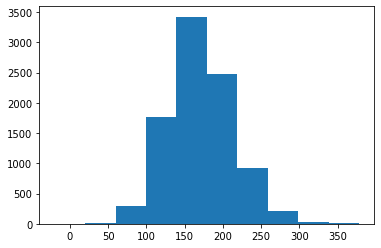

TAT Area (cm2) has 132 missing entries
TAT Area (cm2) has 0 special entries set()


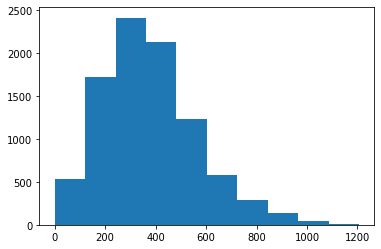

Total Body                Area EA (cm2) has 132 missing entries
Total Body                Area EA (cm2) has 0 special entries set()


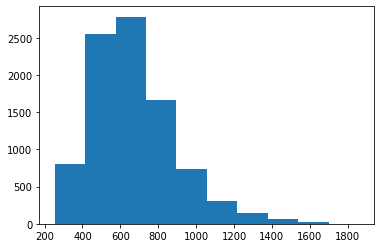

VAT Area (cm2) has 132 missing entries
VAT Area (cm2) has 0 special entries set()


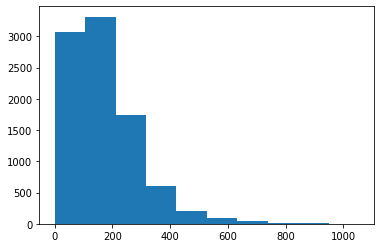

SAT Area (cm2) has 132 missing entries
SAT Area (cm2) has 0 special entries set()


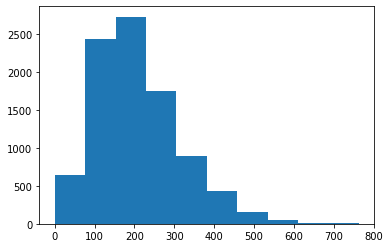

VAT/SAT     Ratio has 133 missing entries
VAT/SAT     Ratio has 0 special entries set()


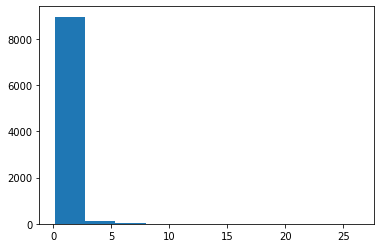

Muscle HU has 28 missing entries
Muscle HU has 0 special entries set()


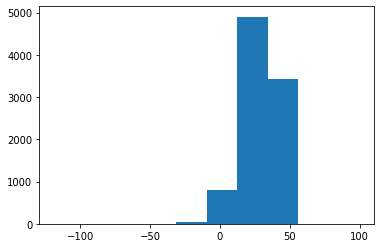

 Muscle Area (cm2) has 28 missing entries
 Muscle Area (cm2) has 0 special entries set()


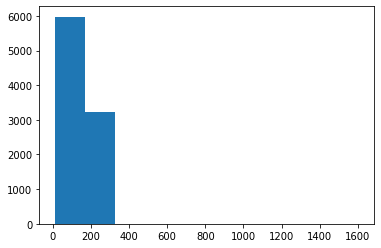

L3 SMI (cm2/m2) has 152 missing entries
L3 SMI (cm2/m2) has 0 special entries set()


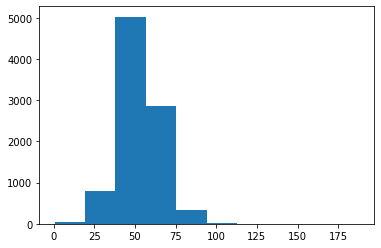

AoCa        Agatston has 1 missing entries
AoCa        Agatston has 0 special entries set()


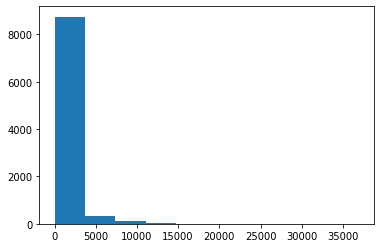

Liver HU    (Median) has 47 missing entries
Liver HU    (Median) has 27 special entries {' '}


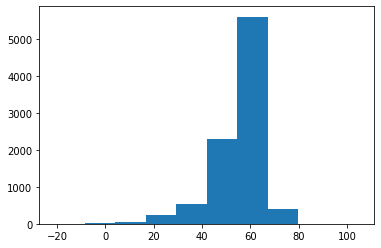

In [10]:
for i in range(14, 25):
    column_name = columns[i]
    result, missing, special = removenan(data2[column_name])
    print(f'{column_name} has {len(missing)} missing entries')
    print(f'{column_name} has {len(special)} special entries', set(special))
    plt.hist(result)
    plt.show()

## Visualize Clinical

Clinical F/U interval  [d from CT] has 0 missing entries
Clinical F/U interval  [d from CT] has 0 special entries set()


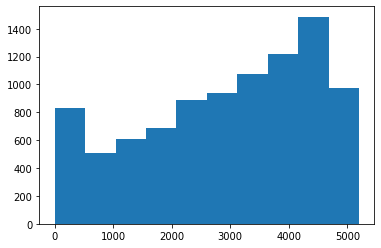

BMI has 123 missing entries
BMI has 0 special entries set()


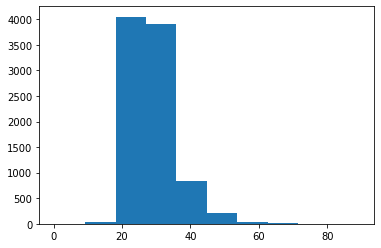

BMI >30 has 123 missing entries
BMI >30 has 0 special entries set()


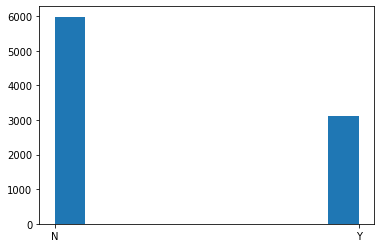

Sex has 0 missing entries
Sex has 0 special entries set()


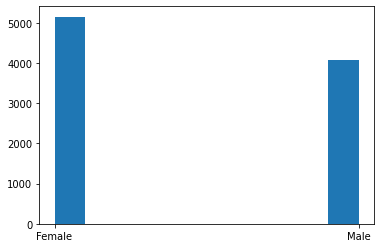

Age at CT has 0 missing entries
Age at CT has 0 special entries set()


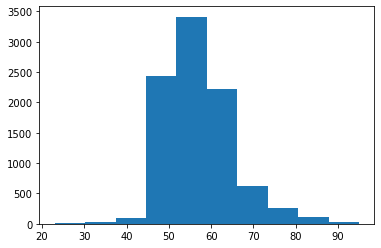

Tobacco has 608 missing entries
Tobacco has 0 special entries set()


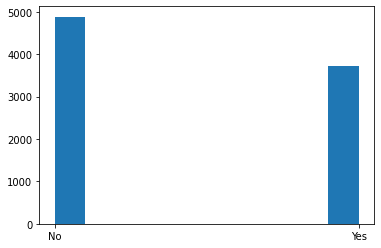

FRS 10-year risk (%) has 0 missing entries
FRS 10-year risk (%) has 2516 special entries {'X', '>30%', '<1%'}


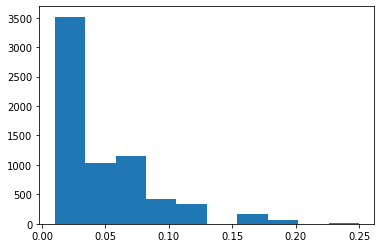

FRAX 10y Fx Prob (Orange-w/ DXA) has 0 missing entries
FRAX 10y Fx Prob (Orange-w/ DXA) has 123 special entries {'_'}


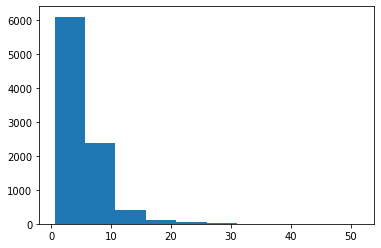

FRAX 10y Hip Fx Prob (Orange-w/ DXA) has 0 missing entries
FRAX 10y Hip Fx Prob (Orange-w/ DXA) has 123 special entries {'_'}


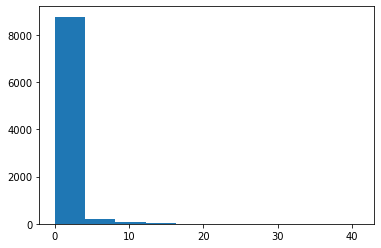

Met Sx has 1438 missing entries
Met Sx has 0 special entries set()


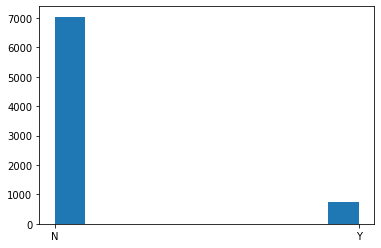

AA_FLAG has 0 missing entries
AA_FLAG has 0 special entries set()


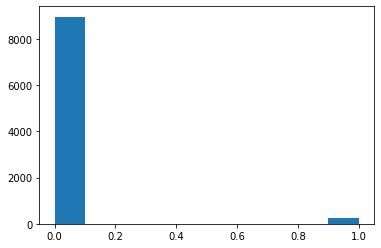

In [11]:
for i in range(3, 14):
    column_name = columns[i]
    result, missing, special = removenan(data2[column_name])
    print(f'{column_name} has {len(missing)} missing entries')
    print(f'{column_name} has {len(special)} special entries', set(special))
    plt.hist(result)
    plt.show()

## Visualize Outcomes

CARD_FLAG has 0 missing entries
CARD_FLAG has 0 special entries set()


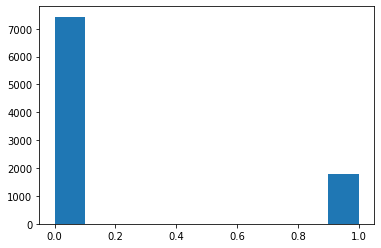

DIA_FLAG has 0 missing entries
DIA_FLAG has 0 special entries set()


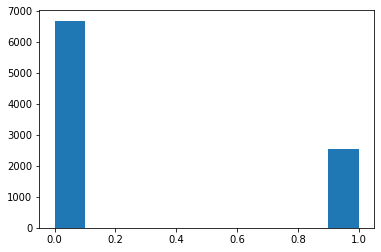

FEM_FLAG has 0 missing entries
FEM_FLAG has 0 special entries set()


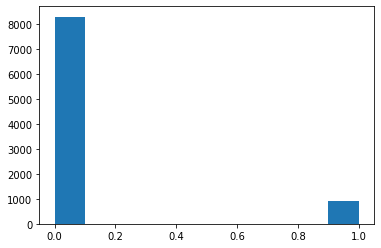

ALZ_FLAG has 0 missing entries
ALZ_FLAG has 0 special entries set()


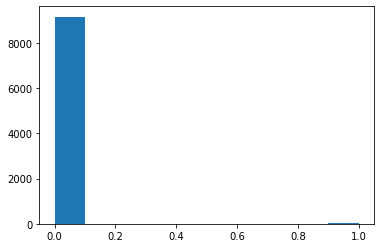

CANCER_FLAG has 0 missing entries
CANCER_FLAG has 0 special entries set()


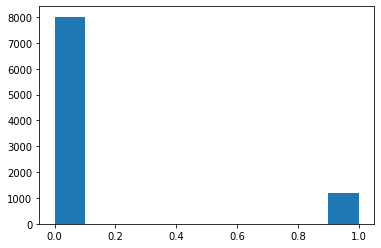

OUTCOME_FLAGS has 0 missing entries
OUTCOME_FLAGS has 0 special entries set()


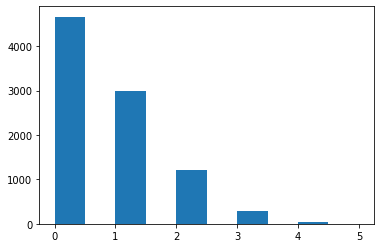

DEATH_FLAG has 0 missing entries
DEATH_FLAG has 0 special entries set()


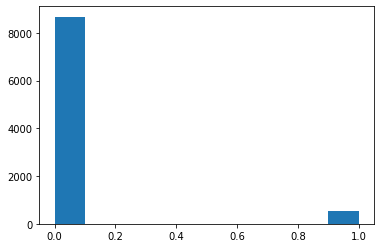

In [12]:
for i in range(25, 32):
    column_name = columns[i]
    result, missing, special = removenan(data2[column_name])
    print(f'{column_name} has {len(missing)} missing entries')
    print(f'{column_name} has {len(special)} special entries', set(special))
    plt.hist(result)
    plt.show()

# Data Cleaning

## Assign Fold

In [13]:
# Aproxx Equal Outcomes in Each Fold
Folds = 5
random.seed(1)
data2 = data2.sample(frac=1)
data2 = data2.sort_values(["CARD_FLAG","DIA_FLAG","FEM_FLAG","ALZ_FLAG","CANCER_FLAG","DEATH_FLAG"]) 
data2 = data2.sort_values("DEATH_FLAG")
data2 = data2.reset_index() 
data2["Fold"] =  data2.index % Folds
data2

index  Record ID  Visit ID   PT ID  Clinical F/U interval  [d from CT]  \
0      2468    10458.0    3448.0  1098.0                              4375.0   
1      1381    11099.0    1888.0  1406.0                              4877.0   
2      3480     3858.0    4940.0  3914.0                              3999.0   
3       342     8344.0    3257.0    69.0                              4293.0   
4      7464     6382.0    8587.0  7891.0                              2330.0   
...     ...        ...       ...     ...                                 ...   
9218   8474     7450.0   11438.0  9728.0                                82.0   
9219   3472     6838.0    4922.0  5957.0                              1401.0   
9220   1664      926.0    2286.0  2089.0                              1730.0   
9221   4683     5267.0    7483.0  4822.0                              2160.0   
9222   4201     4087.0    6461.0  4064.0                               661.0   

       BMI BMI >30     Sex  Age at CT Tobacco  ... AoCa        Agatston  \
0     27.6       N  Female       63.0      No  ...                0.000   
1     30.0       Y    Male       63.0     Yes  ...             1579.818   
2     43.5       Y  Female       42.0      No  ...                0.000   
3     31.3       Y    Male       54.0      No  ...               14.322   
4     29.3       N    Male       56.0     Yes  ...             1805.759   
...    ...     ...     ...        ...     ...  ...                  ...   
9218  34.3       Y    Male       70.0     Yes  ...            21081.402   
9219  34.6       Y    Male       73.0     Yes  ...             4432.919   
9220  34.7       Y    Male       65.0      No  ...             1399.881   
9221  47.0       Y    Male       63.0      No  ...             1085.916   
9222  43.2       Y    Male       52.0     Yes  ...             2416.882   

     Liver HU    (Median) CARD_FLAG DIA_FLAG  FEM_FLAG  ALZ_FLAG  CANCER_FLAG  \
0                      54         0        0         0         0            0   
1                      48         0        1         0         0            0   
2                      48         0        1         0         0            0   
3                      41         0        1         0         0            0   
4                      61         0        1         0         0            0   
...                   ...       ...      ...       ...       ...          ...   
9218                   55         1        0         0         0            0   
9219                   50         1        0         0         0            0   
9220                   55         1        0         0         0            0   
9221                   46         1        0         0         0            0   
9222                   55         0        0         0         0            0   

      OUTCOME_FLAGS  DEATH_FLAG  Fold  
0                 0           0     0  
1                 1           0     1  
2                 1           0     2  
3                 1           0     3  
4                 1           0     4  
...             ...         ...   ...  
9218              1           1     3  
9219              1           1     4  
9220              1           1     0  
9221              1           1     1  
9222              0           1     2  

[9223 rows x 34 columns]

## CT Cleaning

In [14]:
bone_measures = ["L1_HU_BMD"]

fat_measures = ["TAT Area (cm2)","Total Body                Area EA (cm2)", "VAT Area (cm2)", "SAT Area (cm2)", "VAT/SAT     Ratio" ]

muscle_measures = ["Muscle HU", " Muscle Area (cm2)", "L3 SMI (cm2/m2)"]

aortic_measures = ["AoCa        Agatston"]

liver_measures = ["Liver HU    (Median)"]

measures = [bone_measures,fat_measures,muscle_measures,aortic_measures,liver_measures]
measures_all = bone_measures + fat_measures + muscle_measures + aortic_measures + liver_measures


clinical_measures = ["Clinical F/U interval  [d from CT]", "BMI", "BMI >30", "Sex", "Age at CT", "Tobacco", "FRS 10-year risk (%)", "FRAX 10y Fx Prob (Orange-w/ DXA)", "FRAX 10y Hip Fx Prob (Orange-w/ DXA)", "Met Sx", "AA_FLAG",]
clinical_measures_1 = ["BMI", "BMI >30", "Sex", "Age at CT"]
clinical_measures_2 = ["Clinical F/U interval  [d from CT]","Tobacco", "FRS 10-year risk (%)", "FRAX 10y Fx Prob (Orange-w/ DXA)", "FRAX 10y Hip Fx Prob (Orange-w/ DXA)", "Met Sx", "AA_FLAG"]
measures1 = [bone_measures,fat_measures,muscle_measures,aortic_measures,liver_measures,clinical_measures]
ct_clinical_measure = measures_all + clinical_measures
ct_clinical_measure_1 = measures_all + clinical_measures_1
ct_clinical_measure_2 = measures_all + clinical_measures_2

In [15]:
# Convert blanks to NA
data2  = data2.replace("", np.nan, regex=True) # Replace Blanks with NAs
data2  = data2.replace(" ", np.nan, regex=True) # Replace Blanks with NAs

data_cleaned = data2.copy()
for mea in measures1:
    for m in mea:
        data_cleaned = data_cleaned[(data_cleaned[m] != "") & (data_cleaned[m].isnull() == False)]

rmv = len(data2)-len(data_cleaned)
print(rmv, "Remove (" + str(round(rmv*100/len(data2),2)) + "% of data)")


2138 Remove (23.18% of data)


## Clinical Cleaning

In [16]:
data3 = data_cleaned.copy()

# BMI - Remove Outliers (Less than 10 and those with Missing values)
data3 = data3[ (data3["BMI"] > 10)]

# Tobacco - Create new category for the NAs
data3["Tobacco"] = data3["Tobacco"].replace(np.nan, "Not Recorded", regex=True) # Replace Blanks with NAs

# Met Sx - Create new category for the NAs
data3["Met Sx"] = data3["Met Sx"].replace(np.nan, "Not Recorded", regex=True) # Replace Blanks with NAs

# Remove Rows wth Special Characters
data3 = data3[ (data3["FRS 10-year risk (%)"] !=  "X")]
data3 = data3[ (data3["FRAX 10y Fx Prob (Orange-w/ DXA)"] !=  "_")]
data3 = data3[ (data3["FRAX 10y Hip Fx Prob (Orange-w/ DXA)"] !=  "_")]

# Turn these into numeric
data3.loc[(data3["FRS 10-year risk (%)"] == "<1%"),"FRS 10-year risk (%)"] = .005
data3.loc[(data3["FRS 10-year risk (%)"] == ">30%"),"FRS 10-year risk (%)"] = .35

# Remove ID columns becuase no value added
data3 = data3.drop(["Record ID","Visit ID" , "PT ID"],axis = 1)

# Convert remaining blanks to NA
data3  = data3.replace("", np.nan, regex=True) # Replace Blanks with NAs
data3  = data3.replace(" ", np.nan, regex=True) # Replace Blanks with NAs

# turn binary str result to 0 and 1
data3.loc[(data3["BMI >30"]=='N'),"BMI >30"] = 0
data3.loc[(data3["BMI >30"]=='Y'),"BMI >30"] = 1
data3.loc[(data3["Sex"]=='Female'),"Sex"] = 0
data3.loc[(data3["Sex"]=='Male'),"Sex"] = 1
data3.loc[(data3["Tobacco"]=='No'),"Tobacco"] = 0
data3.loc[(data3["Tobacco"]=='Yes'),"Tobacco"] = 1
data3.loc[(data3["Met Sx"]=='N'),"Met Sx"] = 0
data3.loc[(data3["Met Sx"]=='Y'),"Met Sx"] = 1


rmv = len(data_cleaned) - len(data3)
print(str(rmv) + " Removed (" + str(round(rmv*100/len(data2),2)) + "% of data)")

data_cleaned = data3.copy()

36 Removed (0.39% of data)


In [17]:
data_cleaned 

index  Clinical F/U interval  [d from CT]   BMI BMI >30 Sex  Age at CT  \
0      2468                              4375.0  27.6       0   0       63.0   
2      3480                              3999.0  43.5       1   0       42.0   
3       342                              4293.0  31.3       1   1       54.0   
4      7464                              2330.0  29.3       0   1       56.0   
5      5701                              4182.0  35.1       1   0       55.0   
...     ...                                 ...   ...     ...  ..        ...   
9213     48                               997.0  35.0       1   1       88.0   
9215   6117                              3120.0  20.6       0   0       77.0   
9216   8007                              1542.0  20.3       0   0       57.0   
9219   3472                              1401.0  34.6       1   1       73.0   
9222   4201                               661.0  43.2       1   1       52.0   

     Tobacco  FRS 10-year risk (%)  FRAX 10y Fx Prob (Orange-w/ DXA)  \
0          0                 0.010                              6.45   
2          0                 0.005                              1.19   
3          0                 0.030                              3.31   
4          1                 0.060                              4.75   
5          0                 0.010                              4.39   
...      ...                   ...                               ...   
9213       1                 0.160                              5.84   
9215       1                 0.050                              3.61   
9216       1                 0.020                             12.26   
9219       1                 0.160                              5.31   
9222       1                 0.060                              2.15   

      FRAX 10y Hip Fx Prob (Orange-w/ DXA)  ... AoCa        Agatston  \
0                                     0.31  ...                0.000   
2                                     0.03  ...                0.000   
3                                     0.14  ...               14.322   
4                                     0.45  ...             1805.759   
5                                     0.21  ...                0.000   
...                                    ...  ...                  ...   
9213                                  2.32  ...            31723.945   
9215                                  0.13  ...             3345.262   
9216                                  3.20  ...               77.930   
9219                                  1.68  ...             4432.919   
9222                                  0.09  ...             2416.882   

      Liver HU    (Median)  CARD_FLAG  DIA_FLAG  FEM_FLAG  ALZ_FLAG  \
0                     54.0          0         0         0         0   
2                     48.0          0         1         0         0   
3                     41.0          0         1         0         0   
4                     61.0          0         1         0         0   
5                     30.0          0         1         0         0   
...                    ...        ...       ...       ...       ...   
9213                  59.0          1         0         0         0   
9215                  51.0          1         0         0         0   
9216                  58.0          1         0         0         0   
9219                  50.0          1         0         0         0   
9222                  55.0          0         0         0         0   

      CANCER_FLAG  OUTCOME_FLAGS  DEATH_FLAG  Fold  
0               0              0           0     0  
2               0              1           0     2  
3               0              1           0     3  
4               0              1           0     4  
5               0              1           0     0  
...           ...            ...         ...   ...  
9213            0              1           1     3  
9215            0              1      

## CT Prediction

In [18]:
def LR(train,test,X_col=measures_all):
    ct_train_x = train.loc[:,X_col]
    ct_train_y = train.loc[:,"DEATH_FLAG"]
    ct_test_x = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]

    clf_ct_LR = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train_x, ct_train_y)
    pred_y = clf_ct_LR.predict_proba(ct_test_x)
    prob_y_LR = [i[1] for i in pred_y]
    
    return prob_y_LR,ct_test_y

In [19]:
def RF2(train,test,d,X_col=measures_all):
    
    ct_train_x = train.loc[:,X_col]
    ct_train_y = train.loc[:,"DEATH_FLAG"]
    ct_test_x = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]
    
    clf_ct = RandomForestClassifier(max_depth = d,max_samples = .5, n_estimators = 100,random_state=17).fit(ct_train_x, ct_train_y)
    pred_y = clf_ct.predict_proba(ct_test_x)
    prob_y_RF = [i[1] for i in pred_y]
            
    return list(prob_y_RF),list(ct_test_y)
    

In [20]:
def LR_RF2(tr1,tr2,test,d,X_col=measures_all):

    ct_train2_x = tr2.loc[:,X_col]
    ct_train2_x_temp = tr2.loc[:,X_col]
    ct_train2_y = tr2.loc[:,"DEATH_FLAG"]

    ct_test_x = test.loc[:,X_col]
    ct_test_x_temp = test.loc[:,X_col]
    ct_test_y = test.loc[:,"DEATH_FLAG"]
        
    Flags = ["CARD_FLAG","DIA_FLAG","FEM_FLAG","ALZ_FLAG","CANCER_FLAG","DEATH_FLAG"] 
    
    
    
    for f in Flags:
        ct_train1_x = tr1.loc[:,X_col]
        ct_train1_y = tr1.loc[:,f]
        clf_ct_LR = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train1_x, ct_train1_y)
        #clf_ct_LR =  RandomForestClassifier(max_depth = d, n_estimators = 50,random_state=17).fit(ct_train2_x, ct_train2_y)
        
        pred_y = clf_ct_LR.predict_proba(ct_train2_x_temp)
        prob_y_LR = [i[1]for i in pred_y]
        ct_train2_x[f+"_PRED"] = prob_y_LR.copy()

        pred_y = clf_ct_LR.predict_proba(ct_test_x_temp)
        prob_y_LR = [i[1] for i in pred_y]
        ct_test_x[f+"_PRED"] = prob_y_LR.copy()
        

    clf_ct = RandomForestClassifier(max_depth = d,max_samples = .5, n_estimators = 100,random_state=17).fit(ct_train2_x, ct_train2_y)
    #lf_ct = LogisticRegression(random_state=0, solver='liblinear').fit(ct_train2_x, ct_train2_y)
    
    pred_y = clf_ct.predict_proba(ct_test_x)
    prob_y_LR_RF = [i[1] for i in pred_y]

    return list(prob_y_LR_RF),list(ct_test_y)

In [21]:
AUCs_LR = []
FPR_LR = []
TPR_LR = []
TH_LR = []

for f in range(Folds):
    prob_y, true_y = LR(data_cleaned.loc[(data_cleaned["Fold"] != f), ],
                        data_cleaned.loc[(data_cleaned["Fold"] == f), ])

    fpr, tpr, thresholds = metrics.roc_curve(true_y, prob_y)
    auc = metrics.roc_auc_score(true_y, prob_y)
    AUCs_LR.append(auc)
    FPR_LR.append(fpr)
    TPR_LR.append(tpr)
    TH_LR.append(thresholds)

In [22]:
D = [3, 5, 10]

AUCs_RF_All = []
FPR_RF_All = []
TPR_RF_All = []
TH_RF_All = []

for d in D:
    AUCs_RF = []
    FPR_RF = []
    TPR_RF = []
    TH_RF = []
    for f in range(Folds):
        print(f)
        prob_y, true_y = RF2(data_cleaned.loc[(data_cleaned["Fold"] != f), ],
                             data_cleaned.loc[(data_cleaned["Fold"] == f), ],
                             d)

        fpr, tpr, thresholds = metrics.roc_curve(true_y, prob_y)
        auc = metrics.roc_auc_score(true_y, prob_y)
        AUCs_RF.append(auc)
        FPR_RF.append(fpr)
        TPR_RF.append(tpr)
        TH_RF.append(thresholds)

    AUCs_RF_All.append(AUCs_RF)
    FPR_RF_All.append(FPR_RF)
    TPR_RF_All.append(TPR_RF)
    TH_RF_All.append(TH_RF)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


In [23]:
AUCs_LR_RF_All = []
FPR_LR_RF_All = []
TPR_LR_RF_All = []
TH_LR_RF_All = []

for d in D:
    AUCs_LR_RF = []
    FPR_LR_RF = []
    TPR_LR_RF = []
    TH_LR_RF = []
    for f in range(Folds):
        print(f)
        Train_Folds = [ff for ff in range(Folds) if ff != f]
        combs = combinations(Train_Folds, math.ceil((Folds - 1) * .5))

        for c in combs:
            c = list(c)
            prob_y, true_y = LR_RF2(
                data_cleaned.loc[(data_cleaned["Fold"] != f) &
                                 (data_cleaned["Fold"].isin(c)), ],
                data_cleaned.loc[(data_cleaned["Fold"] != f) &
                                 (~data_cleaned["Fold"].isin(c)), ],
                data_cleaned.loc[(data_cleaned["Fold"] == f)], d)

            fpr, tpr, thresholds = metrics.roc_curve(true_y, prob_y)
            auc = metrics.roc_auc_score(true_y, prob_y)
            AUCs_LR_RF.append(auc)
            FPR_LR_RF.append(fpr)
            TPR_LR_RF.append(tpr)
            TH_LR_RF.append(thresholds)

    AUCs_LR_RF_All.append(AUCs_LR_RF)
    FPR_LR_RF_All.append(FPR_LR_RF)
    TPR_LR_RF_All.append(TPR_LR_RF)
    TH_LR_RF_All.append(TH_LR_RF)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


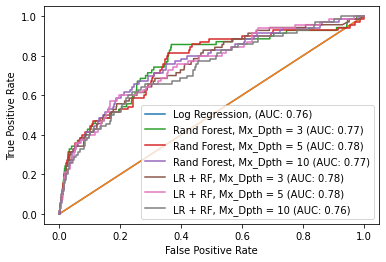

In [24]:
plt.plot(FPR_LR[0], FPR_LR[0], label='Log Regression, (AUC: ' + str(round(sum(AUCs_LR)/len(AUCs_LR),2))+')')
plt.plot([0,1],[0,1])

for d in range(len(D)):
    plt.plot(FPR_RF_All[d][0], TPR_RF_All[d][0], label='Rand Forest, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_RF_All[d])/len(AUCs_RF_All[d]),2))+')')

for d in range(len(D)):
    plt.plot(FPR_LR_RF_All[d][0], TPR_LR_RF_All[d][0], label='LR + RF, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_LR_RF_All[d])/len(AUCs_LR_RF_All[d]),2))+')')

#for d in range(len(D)):
#    plt.plot(FPR_RF_LR_All[d][0], TPR_RF_LR_All[d][0], label='RF + LR, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_RF_LR_All[d])/len(AUCs_RF_LR_All[d]),2))+')')


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

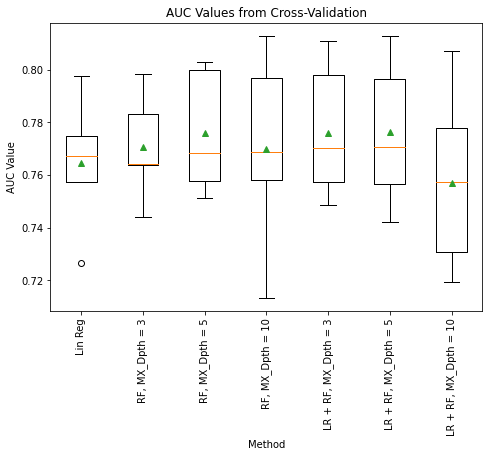

In [25]:

data = [AUCs_LR] +  [ AUCs_RF_All[d] for d in range(len(D))] + [ AUCs_LR_RF_All[d] for d in range(len(D))] 
Labs = ["Lin Reg"] + [ "RF, MX_Dpth = " + str(D[d]) for d in range(len(D))] + [ "LR + RF, MX_Dpth = " + str(D[d]) for d in range(len(D))] 
 
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data,showmeans=True)

ax.set_title('AUC Values from Cross-Validation')
ax.set_xlabel('Method')
ax.set_ylabel('AUC Value')

plt.xticks(list(range(1,1+len(data))), Labs)
ax.set_xticklabels(Labs, rotation = 90)
 
# show plot
plt.show()

## CT + CLINICAL PREDICTION

### CT + Simple Demographics (Sex,Age,BMI)

In [26]:
ct_clinical_measure_1

['L1_HU_BMD',
 'TAT Area (cm2)',
 'Total Body                Area EA (cm2)',
 'VAT Area (cm2)',
 'SAT Area (cm2)',
 'VAT/SAT     Ratio',
 'Muscle HU',
 ' Muscle Area (cm2)',
 'L3 SMI (cm2/m2)',
 'AoCa        Agatston',
 'Liver HU    (Median)',
 'BMI',
 'BMI >30',
 'Sex',
 'Age at CT']

In [27]:
AUCs_LR = []
FPR_LR = []
TPR_LR = []
TH_LR = []

for f in range(Folds):
    prob_y,true_y = LR(data_cleaned.loc[(data_cleaned["Fold"] != f),],
                                data_cleaned.loc[(data_cleaned["Fold"] == f),],X_col=ct_clinical_measure_1)
     
    fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
    auc = metrics.roc_auc_score(true_y,prob_y)
    AUCs_LR.append(auc) 
    FPR_LR.append(fpr) 
    TPR_LR.append(tpr) 
    TH_LR.append(thresholds) 

In [28]:
D = [3,5,10]

AUCs_RF_All = []
FPR_RF_All =[]
TPR_RF_All =[]
TH_RF_All = []

for d in D:
    AUCs_RF = []
    FPR_RF =[]
    TPR_RF =[]
    TH_RF = []
    for f in range(Folds):
        print(f)
        prob_y,true_y = RF2(data_cleaned.loc[(data_cleaned["Fold"] != f),],
                                 data_cleaned.loc[(data_cleaned["Fold"] == f),],
                                 d,X_col=ct_clinical_measure_1)
     
        fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
        auc = metrics.roc_auc_score(true_y,prob_y)
        AUCs_RF.append(auc) 
        FPR_RF.append(fpr) 
        TPR_RF.append(tpr) 
        TH_RF.append(thresholds) 
    
    AUCs_RF_All.append(AUCs_RF)
    FPR_RF_All.append(FPR_RF)
    TPR_RF_All.append(TPR_RF)
    TH_RF_All.append(TH_RF)


0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


In [29]:
AUCs_LR_RF_All = []
FPR_LR_RF_All =[]
TPR_LR_RF_All =[]
TH_LR_RF_All = []

for d in D:
    AUCs_LR_RF = []
    FPR_LR_RF =[]
    TPR_LR_RF =[]
    TH_LR_RF = []
    for f in range(Folds):
        print(f)
        Train_Folds = [ff for ff in range(Folds) if ff != f]
        combs = combinations(Train_Folds, math.ceil((Folds-1)*.5))
        
        for c in combs:
            c= list(c)
            prob_y,true_y = LR_RF2(data_cleaned.loc[(data_cleaned["Fold"] != f) & (data_cleaned["Fold"].isin(c)),],
                                  data_cleaned.loc[(data_cleaned["Fold"] != f) & (~data_cleaned["Fold"].isin(c)),],
                                  data_cleaned.loc[(data_cleaned["Fold"] == f)],
                                  d,X_col=ct_clinical_measure_1)

            fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
            auc = metrics.roc_auc_score(true_y,prob_y)
            AUCs_LR_RF.append(auc) 
            FPR_LR_RF.append(fpr) 
            TPR_LR_RF.append(tpr) 
            TH_LR_RF.append(thresholds) 
    
    AUCs_LR_RF_All.append(AUCs_LR_RF)
    FPR_LR_RF_All.append(FPR_LR_RF)
    TPR_LR_RF_All.append(TPR_LR_RF)
    TH_LR_RF_All.append(TH_LR_RF)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


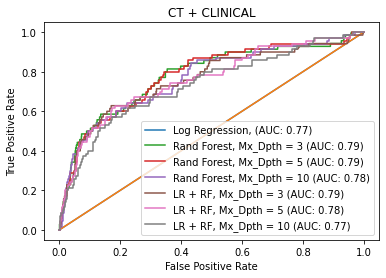

In [30]:
plt.plot(FPR_LR[0], FPR_LR[0], label='Log Regression, (AUC: ' + str(round(sum(AUCs_LR)/len(AUCs_LR),2))+')')
plt.plot([0,1],[0,1])

for d in range(len(D)):
    plt.plot(FPR_RF_All[d][0], TPR_RF_All[d][0], label='Rand Forest, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_RF_All[d])/len(AUCs_RF_All[d]),2))+')')

for d in range(len(D)):
    plt.plot(FPR_LR_RF_All[d][0], TPR_LR_RF_All[d][0], label='LR + RF, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_LR_RF_All[d])/len(AUCs_LR_RF_All[d]),2))+')')


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CT + CLINICAL")
plt.legend()
plt.show()

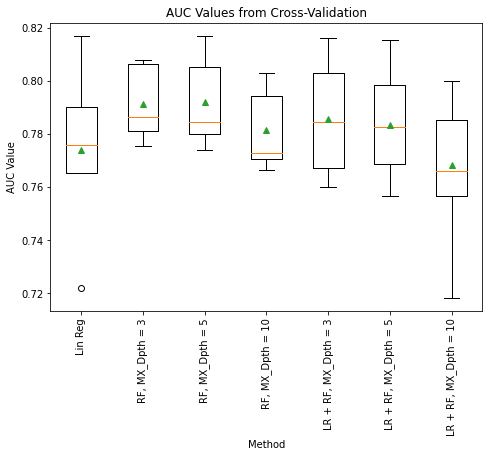

In [31]:
data = [AUCs_LR] +  [ AUCs_RF_All[d] for d in range(len(D))] + [ AUCs_LR_RF_All[d] for d in range(len(D))]
Labs = ["Lin Reg"] + [ "RF, MX_Dpth = " + str(D[d]) for d in range(len(D))] + [ "LR + RF, MX_Dpth = " + str(D[d]) for d in range(len(D))]
 
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data,showmeans=True)

ax.set_title('AUC Values from Cross-Validation')
ax.set_xlabel('Method')
ax.set_ylabel('AUC Value')

plt.xticks(list(range(1,1+len(data))), Labs)
ax.set_xticklabels(Labs, rotation = 90)
 
# show plot
plt.show()

### All CT + Clincal Data

In [32]:
ct_clinical_measure

['L1_HU_BMD',
 'TAT Area (cm2)',
 'Total Body                Area EA (cm2)',
 'VAT Area (cm2)',
 'SAT Area (cm2)',
 'VAT/SAT     Ratio',
 'Muscle HU',
 ' Muscle Area (cm2)',
 'L3 SMI (cm2/m2)',
 'AoCa        Agatston',
 'Liver HU    (Median)',
 'Clinical F/U interval  [d from CT]',
 'BMI',
 'BMI >30',
 'Sex',
 'Age at CT',
 'Tobacco',
 'FRS 10-year risk (%)',
 'FRAX 10y Fx Prob (Orange-w/ DXA)',
 'FRAX 10y Hip Fx Prob (Orange-w/ DXA)',
 'Met Sx',
 'AA_FLAG']

In [33]:
AUCs_LR = []
FPR_LR = []
TPR_LR = []
TH_LR = []

for f in range(Folds):
    prob_y,true_y = LR(data_cleaned.loc[(data_cleaned["Fold"] != f),],
                                data_cleaned.loc[(data_cleaned["Fold"] == f),],X_col=ct_clinical_measure)
     
    fpr, tpr, thresholds = metrics.roc_curve(true_y,prob_y)
    auc = metrics.roc_auc_score(true_y,prob_y)
    AUCs_LR.append(auc) 
    FPR_LR.append(fpr) 
    TPR_LR.append(tpr) 
    TH_LR.append(thresholds)

In [34]:
D = [3, 5, 10]

AUCs_RF_All = []
FPR_RF_All = []
TPR_RF_All = []
TH_RF_All = []

for d in D:
    AUCs_RF = []
    FPR_RF = []
    TPR_RF = []
    TH_RF = []
    for f in range(Folds):
        print(f)
        prob_y, true_y = RF2(data_cleaned.loc[(data_cleaned["Fold"] != f), ],
                             data_cleaned.loc[(data_cleaned["Fold"] == f), ],
                             d,
                             X_col=ct_clinical_measure)

        fpr, tpr, thresholds = metrics.roc_curve(true_y, prob_y)
        auc = metrics.roc_auc_score(true_y, prob_y)
        AUCs_RF.append(auc)
        FPR_RF.append(fpr)
        TPR_RF.append(tpr)
        TH_RF.append(thresholds)

    AUCs_RF_All.append(AUCs_RF)
    FPR_RF_All.append(FPR_RF)
    TPR_RF_All.append(TPR_RF)
    TH_RF_All.append(TH_RF)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


In [35]:
AUCs_LR_RF_All = []
FPR_LR_RF_All = []
TPR_LR_RF_All = []
TH_LR_RF_All = []

for d in D:
    AUCs_LR_RF = []
    FPR_LR_RF = []
    TPR_LR_RF = []
    TH_LR_RF = []
    for f in range(Folds):
        print(f)
        Train_Folds = [ff for ff in range(Folds) if ff != f]
        combs = combinations(Train_Folds, math.ceil((Folds - 1) * .5))

        for c in combs:
            c = list(c)
            prob_y, true_y = LR_RF2(
                data_cleaned.loc[(data_cleaned["Fold"] != f) &
                                 (data_cleaned["Fold"].isin(c)), ],
                data_cleaned.loc[(data_cleaned["Fold"] != f) &
                                 (~data_cleaned["Fold"].isin(c)), ],
                data_cleaned.loc[(data_cleaned["Fold"] == f)],
                d,
                X_col=ct_clinical_measure)

            fpr, tpr, thresholds = metrics.roc_curve(true_y, prob_y)
            auc = metrics.roc_auc_score(true_y, prob_y)
            AUCs_LR_RF.append(auc)
            FPR_LR_RF.append(fpr)
            TPR_LR_RF.append(tpr)
            TH_LR_RF.append(thresholds)

    AUCs_LR_RF_All.append(AUCs_LR_RF)
    FPR_LR_RF_All.append(FPR_LR_RF)
    TPR_LR_RF_All.append(TPR_LR_RF)
    TH_LR_RF_All.append(TH_LR_RF)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


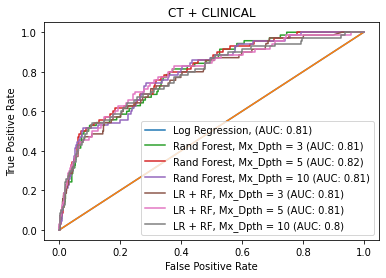

In [36]:
plt.plot(FPR_LR[0], FPR_LR[0], label='Log Regression, (AUC: ' + str(round(sum(AUCs_LR)/len(AUCs_LR),2))+')')
plt.plot([0,1],[0,1])

for d in range(len(D)):
    plt.plot(FPR_RF_All[d][0], TPR_RF_All[d][0], label='Rand Forest, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_RF_All[d])/len(AUCs_RF_All[d]),2))+')')

for d in range(len(D)):
    plt.plot(FPR_LR_RF_All[d][0], TPR_LR_RF_All[d][0], label='LR + RF, Mx_Dpth = '+str(D[d])+' (AUC: ' + str(round(sum(AUCs_LR_RF_All[d])/len(AUCs_LR_RF_All[d]),2))+')')


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CT + CLINICAL")
plt.legend()
plt.show()

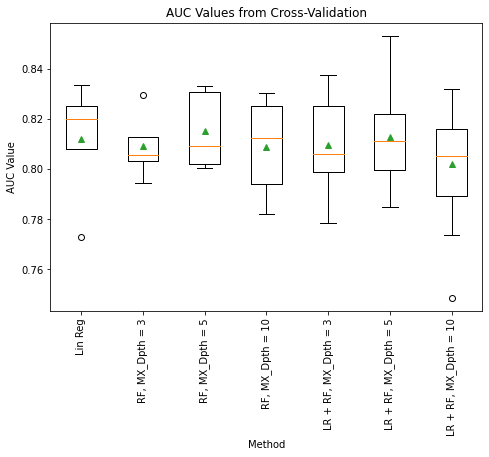

In [37]:
data = [AUCs_LR] +  [ AUCs_RF_All[d] for d in range(len(D))] + [ AUCs_LR_RF_All[d] for d in range(len(D))]
Labs = ["Lin Reg"] + [ "RF, MX_Dpth = " + str(D[d]) for d in range(len(D))] + [ "LR + RF, MX_Dpth = " + str(D[d]) for d in range(len(D))]
 
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data,showmeans=True)

ax.set_title('AUC Values from Cross-Validation')
ax.set_xlabel('Method')
ax.set_ylabel('AUC Value')

plt.xticks(list(range(1,1+len(data))), Labs)
ax.set_xticklabels(Labs, rotation = 90)
 
# show plot
plt.show()

# BIO AGE

In [53]:
def NN_Age(train,test_original,cols,k):
    
    cols = cols + ["risk_prob"]
    cols2 = cols + ["Sex"]
    test = test_original.loc[:,cols2]

    train_sex = {s:train.loc[(train["Sex"] == s),:].copy() for s in range(2)}
    train_sex[0]["dist"] = 0
    train_sex[1]["dist"] = 0
    
    for c in cols:
        std_val = [0,0]
        for s in range(2):
            std_val[s] = train_sex[s][c].std()
            train_sex[s].loc[:,c] = train_sex[s].loc[:,c]/std_val[s]
        for r in test.index:
            s = test.loc[r,"Sex"]
            test.loc[r,c] = test.loc[r,c]/std_val[s]

    test["dist"] = 0
    for r in test.index:
        
        s = test.loc[r,"Sex"]
        train_sex[s]["dist"] = 0
        for c in cols:
            train_sex[s].loc[:,"dist"] += (train_sex[s].loc[:,c] - float(test.loc[r,c]))**2
        
        after_sort = train_sex[s].sort_values("dist")
        
        test.loc[r,"pred_age"] = (after_sort["Age at CT"].iloc[0:k]).mean()
        
    print("done")
    return test["pred_age"] 

In [54]:
prob_list, list_y = LR_RF2(data_cleaned,data_cleaned,data_cleaned,5)

In [55]:
data_cleaned

index  Clinical F/U interval  [d from CT]   BMI BMI >30 Sex  Age at CT  \
0      2468                              4375.0  27.6       0   0       63.0   
2      3480                              3999.0  43.5       1   0       42.0   
3       342                              4293.0  31.3       1   1       54.0   
4      7464                              2330.0  29.3       0   1       56.0   
5      5701                              4182.0  35.1       1   0       55.0   
...     ...                                 ...   ...     ...  ..        ...   
9213     48                               997.0  35.0       1   1       88.0   
9215   6117                              3120.0  20.6       0   0       77.0   
9216   8007                              1542.0  20.3       0   0       57.0   
9219   3472                              1401.0  34.6       1   1       73.0   
9222   4201                               661.0  43.2       1   1       52.0   

     Tobacco  FRS 10-year risk (%)  FRAX 10y Fx Prob (Orange-w/ DXA)  \
0          0                 0.010                              6.45   
2          0                 0.005                              1.19   
3          0                 0.030                              3.31   
4          1                 0.060                              4.75   
5          0                 0.010                              4.39   
...      ...                   ...                               ...   
9213       1                 0.160                              5.84   
9215       1                 0.050                              3.61   
9216       1                 0.020                             12.26   
9219       1                 0.160                              5.31   
9222       1                 0.060                              2.15   

      FRAX 10y Hip Fx Prob (Orange-w/ DXA)  ... DEATH_FLAG  Fold  risk_prob  \
0                                     0.31  ...          0     0   0.023694   
2                                     0.03  ...          0     2   0.023825   
3                                     0.14  ...          0     3   0.049643   
4                                     0.45  ...          0     4   0.069830   
5                                     0.21  ...          0     0   0.034751   
...                                    ...  ...        ...   ...        ...   
9213                                  2.32  ...          1     3   0.583569   
9215                                  0.13  ...          1     0   0.488790   
9216                                  3.20  ...          1     1   0.166204   
9219                                  1.68  ...          1     4   0.212938   
9222                                  0.09  ...          1     2   0.076959   

      Bone_Bio_Age  Fat_Bio_Age  Muscle_Bio_Age  Aortic_Bio_Age  \
0        55.900000    57.357143       61.200000       52.557143   
2        53.428571    57.742857       53.742857       53.128571   
3        54.428571    59.014286       59.885714       55.000000   
4        58.657143    57.328571       55.228571       64.585714   
5        54.257143    60.200000       54.228571       52.557143   
...            ...          ...             ...             ...   
9213     67.271429    56.871429       66.514286       71.514286   
9215     65.442857    55.814286       64.657143       65.842857   
9216     58.914286    54.842857       67.400000       57.257143   
9219     59.928571    59.585714       59.242857       64.057143   
9222     54.871429    59.842857       56.314286       62.214286   

      Liver_Bio_Age     Bio_Age  Age_Adjustment_Days  
0         56.757143   55.713932         -2659.414785  
2         57.071429   40.958211          -380.253157  
3         56.428571   55.148284           419.123533  
4         57.871429   59.244917          1184.394783  
5         56.471429   49.148019         -2135.973243  
...             ...         ...                  ...  
9213      57.428571  107.753065          

In [56]:
tested = []
for f in range(Folds):
    train = data_cleaned.loc[(data_cleaned["Fold"] != f),]
    
    # estimate risk prob
    prob_list, list_y = LR_RF2(train,train,data_cleaned,5)
    data_cleaned["risk_prob"] = prob_list
    test = data_cleaned.loc[(data_cleaned["Fold"] == f),]
    train = data_cleaned.loc[(data_cleaned["Fold"] != f),]
    
    print(f)
    # knn
    k = 70
    test = test.copy()
    test["Bone_Bio_Age"] = NN_Age(train,test,bone_measures,k)
    test["Fat_Bio_Age"] = NN_Age(train,test,fat_measures,k)
    test["Muscle_Bio_Age"] = NN_Age(train,test,muscle_measures,k)
    test["Aortic_Bio_Age"] = NN_Age(train,test,aortic_measures,k)
    test["Liver_Bio_Age"] = NN_Age(train,test,liver_measures,k)
    
    random.seed(20)

    sample_people = train.copy()
    sample_people["decade"] = round(sample_people["Age at CT"],-1)

    sample = [] 
    for f in list(sample_people["decade"].unique()):
        inds = list(sample_people.loc[sample_people["decade"]==f,:].index)
        sample += list(random.sample(inds, min(10,len(inds))))
        
    age_measures = ["Bone_Bio_Age","Fat_Bio_Age","Muscle_Bio_Age","Aortic_Bio_Age","Liver_Bio_Age"]

    Females_Data = train.loc[(train["Sex"] == 0),:]
    Males_Data = train.loc[(train["Sex"] == 1),:]

    Females_Data_samp = train.loc[(train.index.isin(sample))&(train["Sex"] == 0),:]
    Males_Data_samp = train.loc[(train.index.isin(sample))&(train["Sex"] == 1),:]

    Females_Data_samp = Females_Data_samp.copy()
    Females_Data_samp["Bone_Bio_Age"] = NN_Age(train,Females_Data_samp,bone_measures,k)
    Females_Data_samp["Fat_Bio_Age"] = NN_Age(train,Females_Data_samp,fat_measures,k)
    Females_Data_samp["Muscle_Bio_Age"] = NN_Age(train,Females_Data_samp,muscle_measures,k)
    Females_Data_samp["Aortic_Bio_Age"] = NN_Age(train,Females_Data_samp,aortic_measures,k)
    Females_Data_samp["Liver_Bio_Age"] = NN_Age(train,Females_Data_samp,liver_measures,k)
    Males_Data_samp = Males_Data_samp.copy()
    Males_Data_samp["Bone_Bio_Age"] = NN_Age(train,Males_Data_samp,bone_measures,k)
    Males_Data_samp["Fat_Bio_Age"] = NN_Age(train,Males_Data_samp,fat_measures,k)
    Males_Data_samp["Muscle_Bio_Age"] = NN_Age(train,Males_Data_samp,muscle_measures,k)
    Males_Data_samp["Aortic_Bio_Age"] = NN_Age(train,Males_Data_samp,aortic_measures,k)
    Males_Data_samp["Liver_Bio_Age"] = NN_Age(train,Males_Data_samp,liver_measures,k)
    
    reg = {}
    reg[0] = LinearRegression().fit(Females_Data_samp[age_measures],Females_Data_samp["Age at CT"])
    reg[1] = LinearRegression().fit(Males_Data_samp[age_measures],Males_Data_samp["Age at CT"])

    test.loc[:,"Bio_Age"] = 0
    for r in test.index:
        s = test.loc[r,"Sex"]
        m = [test.loc[r,i] for i in age_measures]
        test.loc[r,"Bio_Age"] = reg[s].predict([m])[0]

    test["Age_Adjustment_Days"] = 0
    test["Age_Adjustment_Days"] = (test["Bio_Age"] - test["Age at CT"])*365
    
    tested.append(test.copy())

    
data_cleaned = pd.concat(tested)

0
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
1
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
2
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
3
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
4
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [57]:
data_cleaned = data_cleaned.sort_index()
data_cleaned

index  Clinical F/U interval  [d from CT]   BMI BMI >30 Sex  Age at CT  \
0      2468                              4375.0  27.6       0   0       63.0   
2      3480                              3999.0  43.5       1   0       42.0   
3       342                              4293.0  31.3       1   1       54.0   
4      7464                              2330.0  29.3       0   1       56.0   
5      5701                              4182.0  35.1       1   0       55.0   
...     ...                                 ...   ...     ...  ..        ...   
9213     48                               997.0  35.0       1   1       88.0   
9215   6117                              3120.0  20.6       0   0       77.0   
9216   8007                              1542.0  20.3       0   0       57.0   
9219   3472                              1401.0  34.6       1   1       73.0   
9222   4201                               661.0  43.2       1   1       52.0   

     Tobacco  FRS 10-year risk (%)  FRAX 10y Fx Prob (Orange-w/ DXA)  \
0          0                 0.010                              6.45   
2          0                 0.005                              1.19   
3          0                 0.030                              3.31   
4          1                 0.060                              4.75   
5          0                 0.010                              4.39   
...      ...                   ...                               ...   
9213       1                 0.160                              5.84   
9215       1                 0.050                              3.61   
9216       1                 0.020                             12.26   
9219       1                 0.160                              5.31   
9222       1                 0.060                              2.15   

      FRAX 10y Hip Fx Prob (Orange-w/ DXA)  ... DEATH_FLAG  Fold  risk_prob  \
0                                     0.31  ...          0     0   0.023694   
2                                     0.03  ...          0     2   0.023825   
3                                     0.14  ...          0     3   0.049643   
4                                     0.45  ...          0     4   0.069830   
5                                     0.21  ...          0     0   0.034751   
...                                    ...  ...        ...   ...        ...   
9213                                  2.32  ...          1     3   0.583569   
9215                                  0.13  ...          1     0   0.488790   
9216                                  3.20  ...          1     1   0.166204   
9219                                  1.68  ...          1     4   0.212938   
9222                                  0.09  ...          1     2   0.076959   

      Bone_Bio_Age  Fat_Bio_Age  Muscle_Bio_Age  Aortic_Bio_Age  \
0        55.400000    55.271429       57.171429       54.142857   
2        53.728571    55.985714       52.642857       54.571429   
3        56.128571    57.357143       57.285714       58.142857   
4        61.057143    56.428571       56.000000       60.228571   
5        55.842857    57.342857       52.785714       55.371429   
...            ...          ...             ...             ...   
9213     72.514286    72.414286       73.200000       72.157143   
9215     73.328571    72.442857       72.885714       72.700000   
9216     66.157143    61.871429       66.900000       62.914286   
9219     66.542857    62.085714       67.228571       67.057143   
9222     58.185714    58.000000       55.942857       63.028571   

      Liver_Bio_Age    Bio_Age  Age_Adjustment_Days  
0         53.942857  52.249339         -3923.991270  
2         53.800000  47.446775          1988.072857  
3         55.314286  47.574418         -2345.337439  
4         59.371429  60.527993          1652.717297  
5         54.971429  47.943846         -2575.496322  
...             ...        ...                  ...  
9213      72.585714  89.663562           607.200

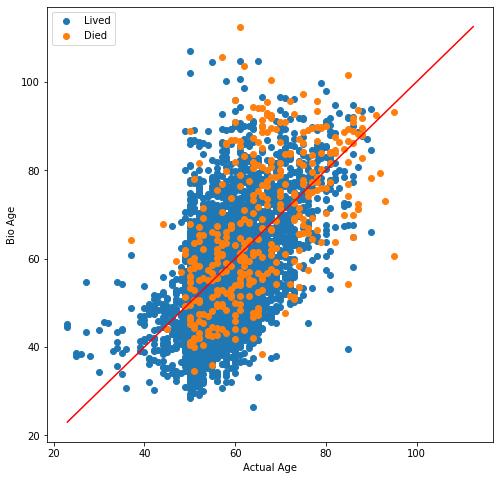

In [58]:
min_temp = min(list(data_cleaned["Age at CT"])+list(data_cleaned["Bio_Age"]))
max_temp =  max(list(data_cleaned["Age at CT"])+list(data_cleaned["Bio_Age"]))

plt.figure(figsize=(8, 8))
lived = (data_cleaned["DEATH_FLAG"] == 0)
dead = (data_cleaned["DEATH_FLAG"] == 1)

plt.plot([min_temp,max_temp ],[min_temp,max_temp],color = "red")

plt.scatter( list(data_cleaned.loc[lived , "Age at CT"]), list(data_cleaned.loc[lived ,"Bio_Age"]),label = "Lived")
plt.scatter( list(data_cleaned.loc[dead,"Age at CT"]), list(data_cleaned.loc[dead,"Bio_Age"]),label = "Died")

plt.xlabel("Actual Age")
plt.ylabel("Bio Age")
plt.legend()


In [59]:
for f in range(Folds):
    diff = []
    for r in data_cleaned.index:
        if data_cleaned.loc[r,"Fold"] == f:
            diff.append(data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"])
    offset = sum(diff)/len(diff)
    print(f'offset={offset}')
    
    bio_age_under_died = 0
    bio_age_over_died= 0 
    bio_age_over_died_age= 0 
    bio_age_under_lived = 0
    bio_age_over_lived = 0 

    lived_age_diff = 0
    died_age_diff = 0

    dead_list = []
    lived_list = []

    for r in data_cleaned.index:
        if data_cleaned.loc[r,"Fold"] == f:
            flag_sum = data_cleaned.loc[r,"CARD_FLAG"] + data_cleaned.loc[r,"DIA_FLAG"] + data_cleaned.loc[r,"FEM_FLAG"] + data_cleaned.loc[r,"ALZ_FLAG"] + data_cleaned.loc[r,"CANCER_FLAG"]
            if data_cleaned.loc[r,"DEATH_FLAG"] == 1:
                dead_list.append(data_cleaned.loc[r,"Bio_Age"])
                died_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
                if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
                    bio_age_under_died += 1
                else:
                    bio_age_over_died += 1

            else:
                lived_list.append(data_cleaned.loc[r,"Bio_Age"])
                lived_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
                if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
                    bio_age_under_lived += 1
                else:
                    bio_age_over_lived += 1

    print(f'dead={bio_age_over_died / (bio_age_over_died + bio_age_under_died)}  total:{bio_age_over_died + bio_age_under_died}')
    print(f'lived={bio_age_over_lived / (bio_age_over_lived + bio_age_under_lived)}  total:{bio_age_over_lived + bio_age_under_lived}')
    print('\n')


offset=-2.4522162544197337
dead=0.6428571428571429  total:70
lived=0.43829468960359014  total:1337


offset=-1.5619362619202593
dead=0.6351351351351351  total:74
lived=0.44698085419734906  total:1358


offset=-2.5934914851144244
dead=0.647887323943662  total:71
lived=0.4162323157110946  total:1343


offset=-3.363581840601776
dead=0.6835443037974683  total:79
lived=0.40566741237882176  total:1341


offset=-3.8128796768543958
dead=0.5342465753424658  total:73
lived=0.44128933231005374  total:1303




In [51]:
#offset = -0
bio_age_under_died = 0
bio_age_over_died= 0 
bio_age_over_died_age= 0 
bio_age_under_lived = 0
bio_age_over_lived = 0 

lived_age_diff = 0
died_age_diff = 0

dead_list = []
lived_list = []

for r in data_cleaned.index:
    flag_sum = data_cleaned.loc[r,"CARD_FLAG"] + data_cleaned.loc[r,"DIA_FLAG"] + data_cleaned.loc[r,"FEM_FLAG"] + data_cleaned.loc[r,"ALZ_FLAG"] + data_cleaned.loc[r,"CANCER_FLAG"]
    if data_cleaned.loc[r,"DEATH_FLAG"] == 1:
        dead_list.append(data_cleaned.loc[r,"Bio_Age"])
        died_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
        if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
            bio_age_under_died += 1
        else:
            bio_age_over_died += 1
            
    else:
        lived_list.append(data_cleaned.loc[r,"Bio_Age"])
        lived_age_diff += data_cleaned.loc[r,"Bio_Age"] - data_cleaned.loc[r,"Age at CT"] - offset
        if data_cleaned.loc[r,"Age at CT"] > data_cleaned.loc[r,"Bio_Age"] - offset:
            bio_age_under_lived += 1
        else:
            bio_age_over_lived += 1
            
print(bio_age_over_died / (bio_age_over_died + bio_age_under_died))
print(bio_age_over_lived / (bio_age_over_lived + bio_age_under_lived))

print(died_age_diff  /  (bio_age_over_died + bio_age_under_died))
print(lived_age_diff / (bio_age_over_lived + bio_age_under_lived))

0.6866485013623979
0.5335228973361269
5.8580195315243815
1.5328810706972755


No handles with labels found to put in legend.


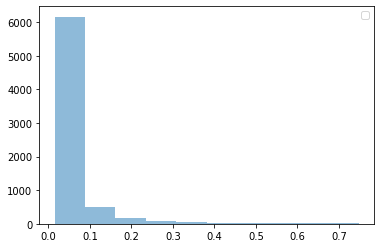

In [52]:
#plt.hist(dead_list, alpha=0.5, label='x')
#plt.hist(lived_list, alpha=0.5, label='y')
dead_actual_age = list(data_cleaned["Age at CT"])
plt.hist(prob_list, alpha=0.5)
plt.legend(loc='upper right')
plt.show()